In [1]:
%matplotlib inline
import copy
import importlib
import pickle

import numpy as np
import matplotlib.pyplot as plt

import keras.backend as K
from keras import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten


from Heatmap import Heatmap
from Environment import Environment
from GaussianTrashSource import GaussianTrashSource



/home/lucas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Parameters

In [2]:
class config:
    
    # General
    n_agents = 3
    number_print = 200

    # Model

    time_steps = 3
    grid_size_w = 10
    grid_size_h = 10
    n_actions = 5
    n_channels = time_steps + time_steps + 1
    
    trash_source_1 = GaussianTrashSource(mean=[7, 2], 
                                         max_y=grid_size_h - 1, 
                                         max_x=grid_size_w - 1, 
                                         cov=[[0, 0], [0, 0]])
    trash_source_2 = GaussianTrashSource(mean=[1, 6],
                                         max_y=grid_size_h - 1,
                                         max_x=grid_size_w - 1,
                                         cov=[[0, 0], [0, 0]])
    trash_source_3 = GaussianTrashSource(mean=[2, 2],
                                         max_y=grid_size_h - 1,
                                         max_x=grid_size_w - 1,
                                         cov=[[0, 0], [0, 0]])
    trash_source_4 = GaussianTrashSource(mean=[6, 7],
                                         max_y=grid_size_h - 1,
                                         max_x=grid_size_w - 1,
                                         cov=[[0, 0], [0, 0]])
    trash_source_5 = GaussianTrashSource(mean=[8, 5],
                                         max_y=grid_size_h - 1,
                                         max_x=grid_size_w - 1,
                                         cov=[[0, 0], [0, 0]])
    trash_source_6 = GaussianTrashSource(mean=[4, 6],
                                         max_y=grid_size_h - 1,
                                         max_x=grid_size_w - 1,
                                         cov=[[0, 0], [0, 0]])
    

    # Q-Learning

    n_episodes = 1
    n_steps = 40000
    epsilon = 0.75
    epsilon_decay = 1 - 1e-5
    gamma = 0.9

## Model

In [3]:
data_i = Input(shape=(config.n_channels, config.grid_size_w, config.grid_size_h))
conv_1 = Conv2D(16, (2, 2), activation="relu", data_format="channels_first")(data_i)
conv_2 = Conv2D(32, (2, 2), activation="relu", data_format="channels_first")(conv_1)
pool_1 = MaxPooling2D(data_format="channels_first")(conv_2)
drop_1 = Dropout(0.25)(pool_1)
flat_1 = Flatten()(drop_1)
feed_1 = Dense(64, activation="relu")(flat_1)
drop_2 = Dropout(0.25)(feed_1)
feed_2 = Dense(config.n_actions, activation="linear")(drop_2)
data_o = feed_2

model = Model(inputs=data_i, outputs=data_o)

model.compile(optimizer="adam", loss="mse")

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 10, 10)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 9, 9)          464       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 4, 4)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 4, 4)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
__________

In [13]:
# read model, and experiment 1 results
all_reward_history = pickle.load(open('Experiments/Exp1/all_reward_history.p','rb'))
avg_reward_history = pickle.load(open('Experiments/Exp1/avg_reward_history.p','rb'))


250

## Q-Learning

In [4]:
from Motion import Motion

def tuple_to_batch(known_data):
    batch = []
    for i,agent_pos in enumerate(known_data[2]):
        batch.append(np.concatenate((known_data[0],known_data[1],known_data[2][i:i+1])))
    batch = np.array(batch)
    return batch

def valid_move_mask(batch):
    mask = np.ones(shape=(config.n_agents, config.n_actions))
    indices = np.array(np.nonzero(batch[:, config.n_channels - 1, :, :])).T
    for idx in indices:
        agent, row, col = idx
        for action in range(config.n_actions):
            d_pos = Motion(action).value
            row += d_pos[0]
            col += d_pos[1]
            if row == -1 or row == config.grid_size_h or col == -1 or col == config.grid_size_w:
                mask[agent, action] = 0
    return mask

In [5]:
def run(model, env, random_moves = True, do_train = True):
    
    for idx, trash_source in enumerate(env.debug_data_export()[4]): 
        print("Trash Source {} has its mean at {}".format(idx, trash_source.mean))

    # init statistics data structures
    all_reward_history = []
    avg_reward_history = []
    all_action_history = np.zeros((config.number_print, 5))
    all_agents_heatmap = Heatmap(keep_track_of_steps=config.number_print, title="Combined position heatmap")
    per_agent_heatmaps = [Heatmap(keep_track_of_steps=config.number_print, title="Agent "+str(i)+" position heatmap") for i in range(config.n_agents)]
    agent_coords = [(4,4),(4,5),(5,4),(5,5),(4,3),(5,3)]
    for k in range(config.n_agents):
        env.add_agent(coord=agent_coords[k], capacity=100000)
        all_reward_history.append([])
        avg_reward_history.append([])
    
    X = tuple_to_batch(env.export_known_data())
    Q_vals = model.predict(X)
    for step in range(config.n_steps):
        
        # get actions
        mask = valid_move_mask(X)
        
        if random_moves and np.random.random() < max(config.epsilon, 0.01):
            Q_rand = np.random.random(config.n_agents * config.n_actions).reshape((config.n_agents, config.n_actions))
            actions = np.apply_along_axis(np.argmax, 1, Q_rand * mask).tolist()
        else:
            actions = np.apply_along_axis(np.argmax, 1, Q_vals * mask).tolist()
        config.epsilon *= config.epsilon_decay
            
        # take actions
        h_trash, h_agents, p_agents, r_agents = env.move_agents(actions)
        X_new = tuple_to_batch([h_trash, h_agents, p_agents])
        
        # update statistics data structures
        all_agents_heatmap.add_map(h_agents[-1])
        all_action_history[step % config.number_print, :] = 0
        all_action_history[step % config.number_print, actions[0]] = 1
        for i in range(config.n_agents):
            all_reward_history[i].append(r_agents[i])
            #per_agent_heatmaps[i].add_map(p_agents[i])
                
        if step % config.number_print == 0:
            # mean reward per agent (list)
            means = [np.mean(reward_history) for reward_history in all_reward_history]
            print("steps {} - {}".format(step - config.number_print, step))
#            print("gamma = {}".format(max(config.epsilon, 0.01)))
#            for i_agent in range(len(means)):
#                print("avg reward for agent", i_agent, ":", means[i_agent])
            
            # plot moving reward averages per agent
            print("")
            for i_agent in range(config.n_agents):
                avg_reward_history[i_agent].append(means[i_agent])
                print("Agent "+str(i_agent)+" avg reward:",means[i_agent])
#                plt.plot(range(0, step+1, config.number_print), avg_reward_history[i_agent], label="Agent "+str(i_agent))
            
#            plt.xlabel("time steps")
#            plt.ylabel("Average reward")
#            plt.legend()
#            plt.show()
            
            # heatmap
#            all_agents_heatmap.show_heatmap()
#            print("Per agent heatmaps:")
#            for heatmap in per_agent_heatmaps:
#                heatmap.show_heatmap()
        
        Q_vals_new = model.predict(X_new)
        
        if do_train:
            Q_vals[range(config.n_agents), actions] = r_agents + config.gamma * np.max(Q_vals_new, axis=1)
            model.fit(X, Q_vals, epochs=1, verbose=0)

        Q_vals = Q_vals_new
        X = X_new
    
    return all_reward_history,avg_reward_history,all_agents_heatmap,per_agent_heatmaps

### Run the model with different numbers of agents in some environment

Trash Source 0 has its mean at [7, 2]
Trash Source 1 has its mean at [1, 6]
Trash Source 2 has its mean at [6, 7]
steps -200 - 0

Agent 0 avg reward: 0.0
steps 0 - 200

Agent 0 avg reward: 0.09950248756218906
steps 200 - 400

Agent 0 avg reward: 0.49875311720698257
steps 400 - 600

Agent 0 avg reward: 0.36605657237936773
steps 600 - 800

Agent 0 avg reward: 0.3995006242197253
steps 800 - 1000

Agent 0 avg reward: 0.4995004995004995
steps 1000 - 1200

Agent 0 avg reward: 0.466278101582015
steps 1200 - 1400

Agent 0 avg reward: 0.44254104211277656
steps 1400 - 1600

Agent 0 avg reward: 0.49968769519050593
steps 1600 - 1800

Agent 0 avg reward: 0.4441976679622432
steps 1800 - 2000

Agent 0 avg reward: 0.42478760619690153
steps 2000 - 2200

Agent 0 avg reward: 0.4497955474784189
steps 2200 - 2400

Agent 0 avg reward: 0.4331528529779259
steps 2400 - 2600

Agent 0 avg reward: 0.46520569011918494
steps 2600 - 2800

Agent 0 avg reward: 0.4462691895751517
steps 2800 - 3000

Agent 0 avg reward: 

steps 27400 - 27600

Agent 0 avg reward: 1.8223977392123474
steps 27600 - 27800

Agent 0 avg reward: 1.8222366101938778
steps 27800 - 28000

Agent 0 avg reward: 1.831006035498732
steps 28000 - 28200

Agent 0 avg reward: 1.8478068153611573
steps 28200 - 28400

Agent 0 avg reward: 1.8516953628393367
steps 28400 - 28600

Agent 0 avg reward: 1.8548302506905352
steps 28600 - 28800

Agent 0 avg reward: 1.8523662372834278
steps 28800 - 29000

Agent 0 avg reward: 1.849246577704217
steps 29000 - 29200

Agent 0 avg reward: 1.8427451114687854
steps 29200 - 29400

Agent 0 avg reward: 1.8434747117444985
steps 29400 - 29600

Agent 0 avg reward: 1.8587209891557717
steps 29600 - 29800

Agent 0 avg reward: 1.870742592530452
steps 29800 - 30000

Agent 0 avg reward: 1.885937135428819
steps 30000 - 30200

Agent 0 avg reward: 1.8946392503559484
steps 30200 - 30400

Agent 0 avg reward: 1.9098055985000493
steps 30400 - 30600

Agent 0 avg reward: 1.9208522597300741
steps 30600 - 30800

Agent 0 avg reward: 1.9

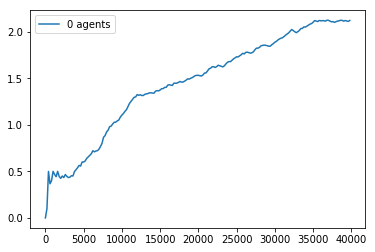

Trash Source 0 has its mean at [7, 2]
Trash Source 1 has its mean at [1, 6]
Trash Source 2 has its mean at [6, 7]
steps -200 - 0

Agent 0 avg reward: 0.0
Agent 1 avg reward: 0.0
steps 0 - 200

Agent 0 avg reward: 0.0
Agent 1 avg reward: 0.6467661691542289
steps 200 - 400

Agent 0 avg reward: 0.24937655860349128
Agent 1 avg reward: 0.4239401496259352
steps 400 - 600

Agent 0 avg reward: 0.28286189683860236
Agent 1 avg reward: 0.5158069883527454
steps 600 - 800

Agent 0 avg reward: 0.299625468164794
Agent 1 avg reward: 0.41198501872659177
steps 800 - 1000

Agent 0 avg reward: 0.38961038961038963
Agent 1 avg reward: 0.32967032967032966
steps 1000 - 1200

Agent 0 avg reward: 0.324729392173189
Agent 1 avg reward: 0.29142381348875934
steps 1200 - 1400

Agent 0 avg reward: 0.32119914346895073
Agent 1 avg reward: 0.371163454675232
steps 1400 - 1600

Agent 0 avg reward: 0.29981261711430357
Agent 1 avg reward: 0.3622735790131168
steps 1600 - 1800

Agent 0 avg reward: 0.3220433092726263
Agent 1 a

steps 16600 - 16800

Agent 0 avg reward: 1.2939705969882744
Agent 1 avg reward: 1.233855127670972
steps 16800 - 17000

Agent 0 avg reward: 1.3040409387683078
Agent 1 avg reward: 1.2428680665843186
steps 17000 - 17200

Agent 0 avg reward: 1.3167839079123307
Agent 1 avg reward: 1.2435323527701878
steps 17200 - 17400

Agent 0 avg reward: 1.3096948451238435
Agent 1 avg reward: 1.2349864950290212
steps 17400 - 17600

Agent 0 avg reward: 1.3107209817624
Agent 1 avg reward: 1.2414067382535083
steps 17600 - 17800

Agent 0 avg reward: 1.3235211504971631
Agent 1 avg reward: 1.2448738834896915
steps 17800 - 18000

Agent 0 avg reward: 1.33603688683962
Agent 1 avg reward: 1.2482639853341482
steps 18000 - 18200

Agent 0 avg reward: 1.3284984341519697
Agent 1 avg reward: 1.2702598758309982
steps 18200 - 18400

Agent 0 avg reward: 1.3488397369708167
Agent 1 avg reward: 1.286343133525352
steps 18400 - 18600

Agent 0 avg reward: 1.3585291113381002
Agent 1 avg reward: 1.291866028708134
steps 18600 - 1880

steps 33400 - 33600

Agent 0 avg reward: 1.5193000208327132
Agent 1 avg reward: 1.4943007648581887
steps 33600 - 33800

Agent 0 avg reward: 1.5280612999615395
Agent 1 avg reward: 1.4916718440282832
steps 33800 - 34000

Agent 0 avg reward: 1.5252492573747831
Agent 1 avg reward: 1.4843681068203876
steps 34000 - 34200

Agent 0 avg reward: 1.5265635507733692
Agent 1 avg reward: 1.4812432385017982
steps 34200 - 34400

Agent 0 avg reward: 1.5223394668759629
Agent 1 avg reward: 1.4819336647190489
steps 34400 - 34600

Agent 0 avg reward: 1.5233663766943153
Agent 1 avg reward: 1.4756798936446924
steps 34600 - 34800

Agent 0 avg reward: 1.5255308755495531
Agent 1 avg reward: 1.4715094393839256
steps 34800 - 35000

Agent 0 avg reward: 1.5205279849147166
Agent 1 avg reward: 1.4659581154824148
steps 35000 - 35200

Agent 0 avg reward: 1.5167182750490042
Agent 1 avg reward: 1.4681401096559756
steps 35200 - 35400

Agent 0 avg reward: 1.510974266263665
Agent 1 avg reward: 1.4660602807830287
steps 35400

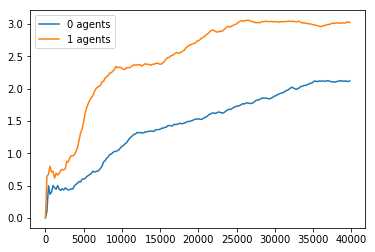

Trash Source 0 has its mean at [7, 2]
Trash Source 1 has its mean at [1, 6]
Trash Source 2 has its mean at [6, 7]
steps -200 - 0

Agent 0 avg reward: 0.0
Agent 1 avg reward: 0.0
Agent 2 avg reward: 0.0
steps 0 - 200

Agent 0 avg reward: 0.04975124378109453
Agent 1 avg reward: 0.29850746268656714
Agent 2 avg reward: 0.44776119402985076
steps 200 - 400

Agent 0 avg reward: 0.19950124688279303
Agent 1 avg reward: 0.24937655860349128
Agent 2 avg reward: 0.4488778054862843
steps 400 - 600

Agent 0 avg reward: 0.21630615640599002
Agent 1 avg reward: 0.3161397670549085
Agent 2 avg reward: 0.415973377703827
steps 600 - 800

Agent 0 avg reward: 0.18726591760299627
Agent 1 avg reward: 0.3121098626716604
Agent 2 avg reward: 0.46192259675405745
steps 800 - 1000

Agent 0 avg reward: 0.14985014985014986
Agent 1 avg reward: 0.24975024975024976
Agent 2 avg reward: 0.4595404595404595
steps 1000 - 1200

Agent 0 avg reward: 0.2331390507910075
Agent 1 avg reward: 0.28309741881765194
Agent 2 avg reward: 0.

steps 11800 - 12000

Agent 0 avg reward: 1.0832430630780767
Agent 1 avg reward: 0.8790934088825931
Agent 2 avg reward: 1.008249312557287
steps 12000 - 12200

Agent 0 avg reward: 1.0687648553397262
Agent 1 avg reward: 0.8769772969428735
Agent 2 avg reward: 1.0072944840586837
steps 12200 - 12400

Agent 0 avg reward: 1.0733005402790097
Agent 1 avg reward: 0.8846060801548262
Agent 2 avg reward: 1.0063704539956455
steps 12400 - 12600

Agent 0 avg reward: 1.068962780731688
Agent 1 avg reward: 0.8848504086977224
Agent 2 avg reward: 0.9943655265455122
steps 12600 - 12800

Agent 0 avg reward: 1.077259589094602
Agent 1 avg reward: 0.878056401843606
Agent 2 avg reward: 0.9842981017108039
steps 12800 - 13000

Agent 0 avg reward: 1.088377817090993
Agent 1 avg reward: 0.8830089993077456
Agent 2 avg reward: 0.9876163372048304
steps 13000 - 13200

Agent 0 avg reward: 1.0946140443905765
Agent 1 avg reward: 0.8825089008408454
Agent 2 avg reward: 0.9787137338080448
steps 13200 - 13400

Agent 0 avg reward

steps 23800 - 24000

Agent 0 avg reward: 1.0737052622807384
Agent 1 avg reward: 0.9353776925961418
Agent 2 avg reward: 0.9641264947293863
steps 24000 - 24200

Agent 0 avg reward: 1.0726829469856618
Agent 1 avg reward: 0.9313664724598157
Agent 2 avg reward: 0.9590512788727739
steps 24200 - 24400

Agent 0 avg reward: 1.0716773902708905
Agent 1 avg reward: 0.9266013687963608
Agent 2 avg reward: 0.9528298020572927
steps 24400 - 24600

Agent 0 avg reward: 1.0869476850534532
Agent 1 avg reward: 0.9308564692492175
Agent 2 avg reward: 0.9483354335189627
steps 24600 - 24800

Agent 0 avg reward: 1.088262570057659
Agent 1 avg reward: 0.934236522720858
Agent 2 avg reward: 0.9479456473529293
steps 24800 - 25000

Agent 0 avg reward: 1.0871565137394503
Agent 1 avg reward: 0.9331626734930603
Agent 2 avg reward: 0.9443622255109796
steps 25000 - 25200

Agent 0 avg reward: 1.085274393873259
Agent 1 avg reward: 0.9309154398634975
Agent 2 avg reward: 0.9396452521725328
steps 25200 - 25400

Agent 0 avg rewa

steps 35800 - 36000

Agent 0 avg reward: 1.0946918141162745
Agent 1 avg reward: 0.9608066442598817
Agent 2 avg reward: 0.9216410655259576
steps 36000 - 36200

Agent 0 avg reward: 1.093339962984448
Agent 1 avg reward: 0.9599182343029198
Agent 2 avg reward: 0.9206927985414768
steps 36200 - 36400

Agent 0 avg reward: 1.0931018378615973
Agent 1 avg reward: 0.9628856350100272
Agent 2 avg reward: 0.9216779758797835
steps 36400 - 36600

Agent 0 avg reward: 1.093685964864348
Agent 1 avg reward: 0.9639080899428978
Agent 2 avg reward: 0.9212863036529056
steps 36600 - 36800

Agent 0 avg reward: 1.094535474579495
Agent 1 avg reward: 0.9646476997907666
Agent 2 avg reward: 0.917366375913698
steps 36800 - 37000

Agent 0 avg reward: 1.0988892192102917
Agent 1 avg reward: 0.9651090511067268
Agent 2 avg reward: 0.9134888246263615
steps 37000 - 37200

Agent 0 avg reward: 1.097819951076584
Agent 1 avg reward: 0.9639525819198409
Agent 2 avg reward: 0.9115346361656945
steps 37200 - 37400

Agent 0 avg reward

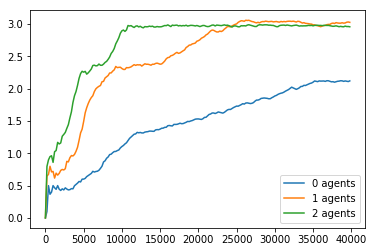

Trash Source 0 has its mean at [7, 2]
Trash Source 1 has its mean at [1, 6]
Trash Source 2 has its mean at [6, 7]
steps -200 - 0

Agent 0 avg reward: 0.0
Agent 1 avg reward: 0.0
Agent 2 avg reward: 0.0
Agent 3 avg reward: 0.0
steps 0 - 200

Agent 0 avg reward: 0.0
Agent 1 avg reward: 0.0
Agent 2 avg reward: 0.04975124378109453
Agent 3 avg reward: 0.09950248756218906
steps 200 - 400

Agent 0 avg reward: 0.07481296758104738
Agent 1 avg reward: 0.14962593516209477
Agent 2 avg reward: 0.19950124688279303
Agent 3 avg reward: 0.04987531172069826
steps 400 - 600

Agent 0 avg reward: 0.09983361064891846
Agent 1 avg reward: 0.16638935108153077
Agent 2 avg reward: 0.19966722129783693
Agent 3 avg reward: 0.033277870216306155
steps 600 - 800

Agent 0 avg reward: 0.1373283395755306
Agent 1 avg reward: 0.24968789013732834
Agent 2 avg reward: 0.16229712858926343
Agent 3 avg reward: 0.08739076154806492
steps 800 - 1000

Agent 0 avg reward: 0.14985014985014986
Agent 1 avg reward: 0.2597402597402597
Age

steps 9200 - 9400

Agent 0 avg reward: 0.8541644505903627
Agent 1 avg reward: 0.7286458887352409
Agent 2 avg reward: 0.7329007552388044
Agent 3 avg reward: 0.673332624188916
steps 9400 - 9600

Agent 0 avg reward: 0.8509530257264868
Agent 1 avg reward: 0.7311738360587439
Agent 2 avg reward: 0.7311738360587439
Agent 3 avg reward: 0.6624309967711697
steps 9600 - 9800

Agent 0 avg reward: 0.8509335782063054
Agent 1 avg reward: 0.7274767880828487
Agent 2 avg reward: 0.7489031731455974
Agent 3 avg reward: 0.6642179369452097
steps 9800 - 10000

Agent 0 avg reward: 0.8449155084491551
Agent 1 avg reward: 0.7279272072792721
Agent 2 avg reward: 0.7479252074792521
Agent 3 avg reward: 0.662933706629337
steps 10000 - 10200

Agent 0 avg reward: 0.8597196353298696
Agent 1 avg reward: 0.7273796686599353
Agent 2 avg reward: 0.7489461817468875
Agent 3 avg reward: 0.656798353102637
steps 10200 - 10400

Agent 0 avg reward: 0.8566483991923853
Agent 1 avg reward: 0.7239688491491203
Agent 2 avg reward: 0.7576

steps 18600 - 18800

Agent 0 avg reward: 0.8536779958512845
Agent 1 avg reward: 0.7685761395670443
Agent 2 avg reward: 0.7238976650178182
Agent 3 avg reward: 0.6467741077602255
steps 18800 - 19000

Agent 0 avg reward: 0.8467975369717383
Agent 1 avg reward: 0.7673280353665597
Agent 2 avg reward: 0.7204883953476133
Agent 3 avg reward: 0.6599652649860533
steps 19000 - 19200

Agent 0 avg reward: 0.8457892818082392
Agent 1 avg reward: 0.7650643195666892
Agent 2 avg reward: 0.7244414353419093
Agent 3 avg reward: 0.6577782407166294
steps 19200 - 19400

Agent 0 avg reward: 0.8427400649451059
Agent 1 avg reward: 0.7618164012164321
Agent 2 avg reward: 0.7267666615122932
Agent 3 avg reward: 0.6551208700582444
steps 19400 - 19600

Agent 0 avg reward: 0.8407734299270445
Agent 1 avg reward: 0.7581245854803327
Agent 2 avg reward: 0.7285342584562012
Agent 3 avg reward: 0.6606805775215551
steps 19600 - 19800

Agent 0 avg reward: 0.8358163729104591
Agent 1 avg reward: 0.7555173981112066
Agent 2 avg rewa

steps 28000 - 28200

Agent 0 avg reward: 0.8187652920109216
Agent 1 avg reward: 0.7396900819119889
Agent 2 avg reward: 0.7535193787454345
Agent 3 avg reward: 0.6797631289670579
steps 28200 - 28400

Agent 0 avg reward: 0.8165205450512306
Agent 1 avg reward: 0.741875286081476
Agent 2 avg reward: 0.753142494982571
Agent 3 avg reward: 0.677793035456498
steps 28400 - 28600

Agent 0 avg reward: 0.8157057445543862
Agent 1 avg reward: 0.7412328240271319
Agent 2 avg reward: 0.7510226915142827
Agent 3 avg reward: 0.6748015803643229
steps 28600 - 28800

Agent 0 avg reward: 0.8152494705044964
Agent 1 avg reward: 0.7364327627512933
Agent 2 avg reward: 0.7534460609006631
Agent 3 avg reward: 0.689559390298948
steps 28800 - 29000

Agent 0 avg reward: 0.8168683838488328
Agent 1 avg reward: 0.7372159580704114
Agent 2 avg reward: 0.7565256370469984
Agent 3 avg reward: 0.6892865763249543
steps 29000 - 29200

Agent 0 avg reward: 0.813670764699839
Agent 1 avg reward: 0.7376459710283895
Agent 2 avg reward: 0

steps 37400 - 37600

Agent 0 avg reward: 0.8031701284540305
Agent 1 avg reward: 0.7701922821201563
Agent 2 avg reward: 0.7412036913911864
Agent 3 avg reward: 0.6928007233850163
steps 37600 - 37800

Agent 0 avg reward: 0.8028888124652787
Agent 1 avg reward: 0.7695563609428322
Agent 2 avg reward: 0.7438956641358694
Agent 3 avg reward: 0.6915160974577392
steps 37800 - 38000

Agent 0 avg reward: 0.8033999105286703
Agent 1 avg reward: 0.7723480961027341
Agent 2 avg reward: 0.7426120365253546
Agent 3 avg reward: 0.6910344464619352
steps 38000 - 38200

Agent 0 avg reward: 0.8033821104159578
Agent 1 avg reward: 0.7722310934268737
Agent 2 avg reward: 0.7402947566817623
Agent 3 avg reward: 0.6902960655480223
steps 38200 - 38400

Agent 0 avg reward: 0.8064894143381682
Agent 1 avg reward: 0.7728965391526262
Agent 2 avg reward: 0.738001614541288
Agent 3 avg reward: 0.690346605557147
steps 38400 - 38600

Agent 0 avg reward: 0.8051604880702572
Agent 1 avg reward: 0.7717416647237119
Agent 2 avg reward

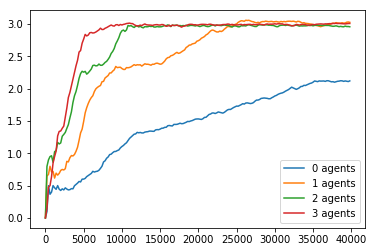

Trash Source 0 has its mean at [7, 2]
Trash Source 1 has its mean at [1, 6]
Trash Source 2 has its mean at [6, 7]
steps -200 - 0

Agent 0 avg reward: 0.0
Agent 1 avg reward: 0.0
Agent 2 avg reward: 0.0
Agent 3 avg reward: 0.0
Agent 4 avg reward: 0.0
steps 0 - 200

Agent 0 avg reward: 0.0
Agent 1 avg reward: 0.14925373134328357
Agent 2 avg reward: 0.29850746268656714
Agent 3 avg reward: 0.14925373134328357
Agent 4 avg reward: 0.24875621890547264
steps 200 - 400

Agent 0 avg reward: 0.24937655860349128
Agent 1 avg reward: 0.09975062344139651
Agent 2 avg reward: 0.3740648379052369
Agent 3 avg reward: 0.12468827930174564
Agent 4 avg reward: 0.5236907730673317
steps 400 - 600

Agent 0 avg reward: 0.23294509151414308
Agent 1 avg reward: 0.16638935108153077
Agent 2 avg reward: 0.415973377703827
Agent 3 avg reward: 0.1497504159733777
Agent 4 avg reward: 0.4492512479201331
steps 600 - 800

Agent 0 avg reward: 0.18726591760299627
Agent 1 avg reward: 0.16229712858926343
Agent 2 avg reward: 0.4494

steps 7600 - 7800

Agent 0 avg reward: 0.5589027047814383
Agent 1 avg reward: 0.6473529034739136
Agent 2 avg reward: 0.6114600692218947
Agent 3 avg reward: 0.4973721317779772
Agent 4 avg reward: 0.640943468786053
steps 7800 - 8000

Agent 0 avg reward: 0.5499312585926759
Agent 1 avg reward: 0.6461692288463942
Agent 2 avg reward: 0.6111736032995876
Agent 3 avg reward: 0.4899387576552931
Agent 4 avg reward: 0.641169853768279
steps 8000 - 8200

Agent 0 avg reward: 0.5584684794537251
Agent 1 avg reward: 0.6499207413730033
Agent 2 avg reward: 0.6072430191440068
Agent 3 avg reward: 0.49506157785635896
Agent 4 avg reward: 0.6291915620046336
steps 8200 - 8400

Agent 0 avg reward: 0.5630282109272705
Agent 1 avg reward: 0.6475419592905607
Agent 2 avg reward: 0.6130222592548507
Agent 3 avg reward: 0.4868468039519105
Agent 4 avg reward: 0.6261159385787406
steps 8400 - 8600

Agent 0 avg reward: 0.5673758865248227
Agent 1 avg reward: 0.6394605278455994
Agent 2 avg reward: 0.6103941402162539
Agent 3 a

steps 15400 - 15600

Agent 0 avg reward: 0.6031664636882251
Agent 1 avg reward: 0.6422665213768348
Agent 2 avg reward: 0.6185500929427601
Agent 3 avg reward: 0.5538106531632587
Agent 4 avg reward: 0.5890648035382348
steps 15600 - 15800

Agent 0 avg reward: 0.6024935130687931
Agent 1 avg reward: 0.6410986646414784
Agent 2 avg reward: 0.6195810391747357
Agent 3 avg reward: 0.5531295487627366
Agent 4 avg reward: 0.5847731156255933
steps 15800 - 16000

Agent 0 avg reward: 0.5993375414036622
Agent 1 avg reward: 0.6393350415599025
Agent 2 avg reward: 0.6218361352415473
Agent 3 avg reward: 0.5512155490281857
Agent 4 avg reward: 0.5843384788450722
steps 16000 - 16200

Agent 0 avg reward: 0.6061354237392753
Agent 1 avg reward: 0.6394666995864453
Agent 2 avg reward: 0.6228010616628603
Agent 3 avg reward: 0.5493488056292821
Agent 4 avg reward: 0.5839145731744954
steps 16200 - 16400

Agent 0 avg reward: 0.6030120114627157
Agent 1 avg reward: 0.6408145844765563
Agent 2 avg reward: 0.628010487165416

steps 23200 - 23400

Agent 0 avg reward: 0.6298876116405282
Agent 1 avg reward: 0.6559548737233452
Agent 2 avg reward: 0.6375795906157856
Agent 3 avg reward: 0.5422845177556515
Agent 4 avg reward: 0.5619417973590872
steps 23400 - 23600

Agent 0 avg reward: 0.6279394940892336
Agent 1 avg reward: 0.6559044108300496
Agent 2 avg reward: 0.6342951569848735
Agent 3 avg reward: 0.5410787678488199
Agent 4 avg reward: 0.5605694673954493
steps 23600 - 23800

Agent 0 avg reward: 0.6272845678752994
Agent 1 avg reward: 0.6533338935338852
Agent 2 avg reward: 0.6356875761522625
Agent 3 avg reward: 0.5457753875887568
Agent 4 avg reward: 0.5579597495903533
steps 23800 - 24000

Agent 0 avg reward: 0.6295571017874255
Agent 1 avg reward: 0.6528894629390442
Agent 2 avg reward: 0.6320569976250989
Agent 3 avg reward: 0.5483104870630391
Agent 4 avg reward: 0.561643264863964
steps 24000 - 24200

Agent 0 avg reward: 0.6268336019172761
Agent 1 avg reward: 0.651625965869179
Agent 2 avg reward: 0.6350977232345771


steps 31000 - 31200

Agent 0 avg reward: 0.6390820807025416
Agent 1 avg reward: 0.6454921316624467
Agent 2 avg reward: 0.6256209736867409
Agent 3 avg reward: 0.5688920226915803
Agent 4 avg reward: 0.5573539309637512
steps 31200 - 31400

Agent 0 avg reward: 0.6378777745931659
Agent 1 avg reward: 0.6461577656762524
Agent 2 avg reward: 0.6276870163370594
Agent 3 avg reward: 0.569090156364447
Agent 4 avg reward: 0.5576255533263272
steps 31400 - 31600

Agent 0 avg reward: 0.6401696148856049
Agent 1 avg reward: 0.6436505173886903
Agent 2 avg reward: 0.6281446789658555
Agent 3 avg reward: 0.5680199993671087
Agent 4 avg reward: 0.5572608461757539
steps 31600 - 31800

Agent 0 avg reward: 0.6430615389453161
Agent 1 avg reward: 0.6430615389453161
Agent 2 avg reward: 0.6314266846954498
Agent 3 avg reward: 0.5675922140813182
Agent 4 avg reward: 0.5559573598314519
steps 31800 - 32000

Agent 0 avg reward: 0.642792412737102
Agent 1 avg reward: 0.6418549420330615
Agent 2 avg reward: 0.6340426861660573


steps 38800 - 39000

Agent 0 avg reward: 0.6340863054793466
Agent 1 avg reward: 0.6299838465680367
Agent 2 avg reward: 0.6453680674854491
Agent 3 avg reward: 0.5546011640727161
Agent 4 avg reward: 0.5604984487577241
steps 39000 - 39200

Agent 0 avg reward: 0.6334022091273181
Agent 1 avg reward: 0.6288104895283284
Agent 2 avg reward: 0.6466671768577332
Agent 3 avg reward: 0.5538124027448279
Agent 4 avg reward: 0.5632509374760848
steps 39200 - 39400

Agent 0 avg reward: 0.6342478617293977
Agent 1 avg reward: 0.6273952437755387
Agent 2 avg reward: 0.6464302936473694
Agent 3 avg reward: 0.5520164462830892
Agent 4 avg reward: 0.5636912768711454
steps 39400 - 39600

Agent 0 avg reward: 0.6328123027196283
Agent 1 avg reward: 0.6259942930734073
Agent 2 avg reward: 0.6461958031362844
Agent 3 avg reward: 0.5512487058407616
Agent 4 avg reward: 0.5648847251332038
steps 39600 - 39800

Agent 0 avg reward: 0.6331499208562599
Agent 1 avg reward: 0.6261149217356348
Agent 2 avg reward: 0.644707419411572

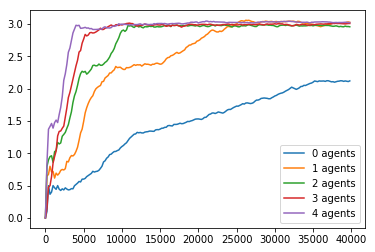

In [6]:
from operator import add
all_reward_histories = []
avg_reward_histories = []
sum_reward_histories = []

eps = config.epsilon
for num_agents in range(1,6):
    config.n_agents = num_agents
    config.epsilon = eps
    model.load_weights('random_model.h5')
    env = Environment(dim=(config.grid_size_h, config.grid_size_w),
                      reward_eat_trash=10, 
                      reward_invalid_move=0,
                      reward_nothing_happend=0, 
                      trash_appearence_prob=0.1,
                      number_trash_sources=0,
                      saved_timesteps=config.time_steps)
    env.trash_sources.append(config.trash_source_1)# at [7,2]
    env.trash_sources.append(config.trash_source_2)# at [1,6]
    env.trash_sources.append(config.trash_source_4)# at [6,7]

    all_reward_history,avg_reward_history,_,_ = run(model,env)
    
    # store reward histories
    all_reward_histories.append(all_reward_history)
    avg_reward_histories.append(avg_reward_history)
    # combine agents histories to an overall history
    sum_reward_history = [0]*len(avg_reward_history[0])
    for history in avg_reward_history:
        sum_reward_history = list(map(add, sum_reward_history, history))
    sum_reward_histories.append(sum_reward_history)
    
    # intermediate plot
    for n_agents, h in enumerate(sum_reward_histories):
        plt.plot(range(0, config.number_print*len(h), config.number_print), h, label=str(n_agents)+" agents")
    plt.legend()
    plt.show()

In [7]:
import pickle
pickle.dump(sum_reward_histories,open("sum_reward_histories.p","wb"))

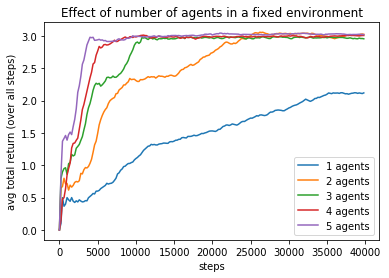

In [14]:
for n_agents, h in enumerate(sum_reward_histories):
    plt.plot(range(0, config.number_print*len(h), config.number_print), h, label=str(n_agents+1)+" agents")
    plt.legend()
plt.xlabel("steps")
plt.ylabel("avg total return (over all steps)")
plt.title("Effect of number of agents in a fixed environment")
plt.show()